In [6]:
import torch
from torch import nn
import matplotlib.pyplot as plt


In [7]:
def read_data():
    with open('../rnn/the_time_machine.txt', 'r') as txt:
        lines = txt.readlines()
    import re
    return [
        l for l in
        [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
        if l.strip() != ''
    ]
def tokenize(data):
    return [ch for line in data for ch in list(line)]
class Vocab:
    
    def __init__(self, tokens) -> None:
        import collections
        counter = collections.Counter(tokens)
        tokens = [ k for k, _ in sorted(counter.items(), key=lambda item: item[1], reverse=True) ]
        tokens.insert(0, '<unk>')
        self.tokens_indicates = { token: idx for idx, token in enumerate(tokens)}
        self.indicates_tokens = { v: k for k, v in self.tokens_indicates.items()}
    
    @property
    def unk(self):
        return 0
    
    def __len__(self):
        return len(self.tokens_indicates)
    
    def __getitem__(self, keys):
        if isinstance(keys, str):
            return self.tokens_indicates[keys]
        if isinstance(keys, list):
            return [self.__getitem__(key) for key in keys]
        if isinstance(keys, (torch.Tensor)):
            keys = keys.reshape(-1)
            return ''.join(self.indicates_tokens[int(keys[i])] for i in range(keys.numel()))
        return self.indicates_tokens[keys]
def build_data(tokens):
    vocab = Vocab(tokens=tokens)
    corpus = [vocab[t] for t in tokens]
    return corpus, vocab

def dataloader(steps, batch_size=2):    
    import random
    corpus, vocab = build_data(tokenize(read_data()))
    _len = len(corpus)
    def _train_iter():
        _discard = random.randint(0, _len - 1)
        _corpus = corpus[_discard:]
        m = (_len - _discard) // steps
        coll = []
        indicates = list(range(m))
        random.shuffle(indicates)
        batch_x, batch_y = [], []
        for i in indicates:
            start = i * steps
            end = (i + 1) * steps
            x = _corpus[start:end]
            y = _corpus[start+1:end+1]
            if len(x) == steps and len(y) == steps:
                batch_x.append(x)
                batch_y.append(y)
            if len(batch_x) == batch_size:
                yield torch.tensor(batch_x, dtype=torch.int64), torch.tensor(batch_y, dtype=torch.int64)
                batch_x, batch_y = [], []
    while True:
        yield _train_iter(), vocab

In [8]:
class SampleLSTM(nn.Module):
    
    def __init__(self, vocab_size, n_hidden, std=1e-2, **kwargs) -> None:
        super(**kwargs).__init__()
        self.vocab_size = vocab_size
        # parameters of input gate
        self.w_xi = nn.Parameter(torch.randn(vocab_size, n_hidden) * std)
        self.w_hi = nn.Parameter(torch.randn(n_hidden, n_hidden) * std)
        self.b_i = nn.Parameter(torch.zeros(size=(n_hidden,)))
        
        # parameters of output gate
        self.w_xo = nn.Parameter(torch.randn(vocab_size, n_hidden) * std)
        self.w_ho = nn.Parameter(torch.randn(n_hidden, n_hidden) * std)
        self.b_o = nn.Parameter(torch.zeros(size=(n_hidden,)))
        
        # parameters of forget gate
        self.w_xf = nn.Parameter(torch.randn(vocab_size, n_hidden) * std)
        self.w_hf = nn.Parameter(torch.randn(n_hidden, n_hidden) * std)
        self.b_f = nn.Parameter(torch.zeros(size=(n_hidden,)))

        # parameters of memory cell
        self.w_xc = nn.Parameter(torch.randn(vocab_size, n_hidden) * std)
        self.w_hc = nn.Parameter(torch.randn(n_hidden, n_hidden) * std)
        self.b_c = nn.Parameter(torch.zeros(size=(n_hidden,)))
        
        self.fc = nn.Linear(n_hidden, vocab_size)
    
    def forward(self, x, state=None):
        # x.T.shape = (step, batch_size)
        if len(x.shape) < 2:
            x = x.unsqueeze(1)
        x = torch.nn.functional.one_hot(x.T, self.vocab_size).to(dtype=torch.float32)
        # (batch_size, step, input) to (step, batch_size, input)
        # x = x.permute((1, 0, 2))
        h, c = (None, None) if state is None else state
        outputs = []
        for step in x:
            # through the `step` dimension for updating state
            
            # calculate input gate
            input_gate = torch.sigmoid((step @ self.w_xi) + (0. if h is None else h @ self.w_hi) + self.b_i)
            if h is None:
                h, c = torch.zeros_like(input_gate), torch.zeros_like(input_gate)
            # calculate output gate
            output_gate = torch.sigmoid((step @ self.w_xo) + (h @ self.w_ho) + self.b_o)
            # calculate forget gate
            forget_gate = torch.sigmoid((step @ self.w_xf) + (h @ self.w_hf) + self.b_f)

            # candidate memory cell
            candidate_cell = torch.tanh((step @ self.w_xc) + (h @ self.w_hc) + self.b_c)
            # memory cell
            cell = forget_gate * c + input_gate * candidate_cell
            
            # determinate current hidden state
            state = output_gate * torch.tanh(cell)
            outputs.append(self.fc(state))
        return torch.stack(outputs, dim=1), (state, cell)

In [9]:
def grad_clip(net: nn.Module, clip_val=1):
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > clip_val:
        for parm in params:
            parm.grad[:] *= clip_val / norm

epoch: [100/100


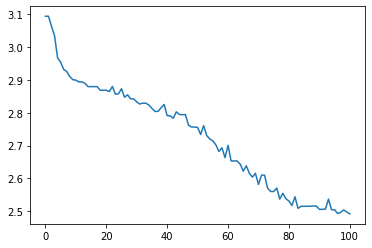

In [10]:
# training the rnn model
dl = dataloader(32, batch_size=1024)
_, vocab = next(dl)
net = SampleLSTM(vocab_size=len(vocab), n_hidden=32)
epochs = 100
optimizer = torch.optim.SGD(net.parameters(), lr=2)
loss_fn = torch.nn.CrossEntropyLoss()
net.zero_grad()
losses = []
for epoch in range(0, epochs + 1):
    train_iter, _ = next(dl)
    for x, y in train_iter:
        optimizer.zero_grad()
        # 1024 32 28
        y_hat, _ = net(x)
        y_hat = y_hat.permute((0, 2, 1))
        # y_hat = torch.reshape(y_hat, (-1, y_hat.shape[-1]))
        # y = torch.nn.functional.one_hot(y, net.vocab_size).to(dtype=torch.float32)
        loss = loss_fn(y_hat, y)
        with torch.no_grad():
            loss.backward()
            grad_clip(net)
            optimizer.step()
    print(f"\repoch: [{epoch}/{epochs}", end='')
    losses.append(loss.detach().numpy())
    # print(f'loss: {loss: .6f}')
print()
plt.plot(losses)

In [11]:
def predict(input, num_preds, vocab, net):
    # warmup
    state = None
    output = []
    softmax = torch.nn.LogSoftmax(dim=2)
    for ch in input:
        x = torch.tensor([vocab[ch]])
        # x = x.reshape((1,1,1))
        _, state = net(x, state)
        output.append(x)
    for i in range(num_preds):
        x = output[-1]
        # x = x.reshape((1,1,1))
        y_hat, state = net(x, state)
        y_hat = softmax(y_hat)
        y_hat = torch.argmax(y_hat, dim=2)
        output.append(y_hat.detach())
    return ''.join(vocab[output])
predict("the time machine", 100, vocab, net)

'the time machine the the the the the the the the the the the the the the the the the the the the the the the the the'